<a href="https://www.kaggle.com/code/taisei7/road-accident-risk-eda-baseline-modeling?scriptVersionId=268831886" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="background-color: #004a99; padding: 25px; border-radius: 10px; text-align: center; margin-bottom: 25px;">
    <h1 style="color: #ffffff; margin: 0; font-size: 2.5em; font-weight: bold;">
         Road Accident Risk 
    </h1>
    <p style="color: #e0f2f7; font-size: 1.4em; margin-top: 10px;">
        EDA & Baseline Modeling
    </p>
</div>

<div style="border: 2px solid #aed6f1; border-radius: 8px; padding: 25px; background-color: #f8f9fa; margin-bottom: 25px;">

<h2 style="color: #2980b9; border-bottom: 3px solid #aed6f1; padding-bottom: 5px; font-size: 1.8em;">
         1.1. Objective
    </h2>
    <p style="font-size: 1.1em; color: #34495e; line-height: 1.6;">
        The primary goal of this notebook is to analyze the factors contributing to road accident severity and to build baseline models to predict the <b>accident risk</b> (our target variable). By understanding the key features, we aim to provide insights that could potentially help in risk mitigation.
    </p>

<h2 style="color: #2980b9; border-bottom: 3px solid #aed6f1; padding-bottom: 5px; font-size: 1.8em; margin-top: 20px;">
         1.2. Dataset
    </h2>
    <p style="font-size: 1.1em; color: #34495e; line-height: 1.6;">
        The dataset provides a comprehensive record of road accidents, including various features such as weather conditions, Curvature, time of day, and Number of the reported accidents.
    </p>

<h2 style="color: #2980b9; border-bottom: 3px solid #aed6f1; padding-bottom: 5px; font-size: 1.8em; margin-top: 20px;">
         1.3. Our Approach
    </h2>
    <p style="font-size: 1.1em; color: #34495e; line-height: 1.6;">
        Our analysis will follow a structured path:
    </p>
    <ul style="font-size: 1.1em; color: #34495e; line-height: 1.7; margin-top: 10px;">
        <li><b>Data Loading:</b> Handle missing or duplicating values.</li>
        <li><b>Exploratory Data Analysis (EDA):</b> Visualize key relationships and insights.</li>
        <li><b>Feature Engineering:</b>Creating new features.</li>
        <li><b>Baseline Modeling:</b> Train LightGBM, XGBoost, and CatBoost models.</li>
        <li><b>Feature Importance:</b> Identify the most predictive factors using Permutation Importance.</li>
    </ul>
</div>

# Table of Contents

- Importing Libraries
- Load Data
- EDA
- Cross-Validation
- Preprocessing, Feature Engineering, Model Training
- Stacking
- Importance Measurement

---

# <font color="blue">1. Importing Libraries</font>

In [1]:
%%capture
!pip install --upgrade scikit-learn

In [2]:
%%capture
!pip install catboost

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Suppress warnings displayed when using deprecated functions in Python libraries
import warnings
warnings.filterwarnings('ignore')
#Make terminal output visually appealing and easy to use
from rich.console import Console
from rich.table import Table
#Style settings for changing the appearance of graphs in Python's Matplotlib library
plt.style.use("ggplot")

sns.set(font_scale=1.1)

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.impute import SimpleImputer

import xgboost as xgb
import catboost as cb

from sklearn.linear_model import LinearRegression

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# <font color="blue">2.Load Data</font>

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s5e10/train.csv',index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv',index_col='id')

In [5]:
train.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


## <font color="green"> Output the characteristics of the dataset in tabular format</font>


In [6]:
#In addition to summary statistics for numerical data in Pandas DataFrames, calculate and clearly display skewness and kurtosis.
def custom_describe(df,categorical=False):
  if not categorical:
    df=df.select_dtypes(include=np.number)
    des=df.describe().T.round(2)
    des['count']=des['count'].astype(int)
    des['skewness']=df.skew().round(2)
    des['kurtosis']=df.kurtosis().round(2)
  return des

In [7]:
def df_summary(df, label="Train"):
    console = Console()
    console.rule(f"[bold blue]{label} DataFrame Description[/bold blue]")
    console.print(f"[bold]Shape:[/bold] {df.shape}\n")

    # Numeric summary
    numeric_cols = df.select_dtypes(include=np.number).columns
    if len(numeric_cols) > 0:
        console.print("[bold blue]Numerical Columns:[/bold blue]")
        num_stats = custom_describe(df[numeric_cols], categorical=False)
        table = Table(show_header=True, header_style="bold magenta")
        table.add_column("Column")
        for col in num_stats.columns:
            table.add_column(col)
        for idx, row in num_stats.iterrows():
            table.add_row(idx, *[f"{val:.2f}" if isinstance(val, (float, np.float64)) else str(val) for val in row])
        console.print(table)
        console.print("\n")

    # Categorical summary
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(cat_cols) > 0:
        console.print("[bold blue]Categorical Columns:[/bold blue]")
        cat_stats = df[cat_cols].describe().T
        table = Table(show_header=True, header_style="bold magenta")
        table.add_column("Column")
        for col in cat_stats.columns:
            table.add_column(col)
        for idx, row in cat_stats.iterrows():
            table.add_row(idx, *[str(val) for val in row])
        console.print(table)
        console.print("\n")

df_summary(train)
df_summary(test, "Test")

─────────────────────────────────────────── Train DataFrame Description ───────────────────────────────────────────

Shape: (517754, 13)

Numerical Columns:

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Column                ┃ count     ┃ mean  ┃ std   ┃ min   ┃ 25%   ┃ 50%   ┃ 75%   ┃ max   ┃ skewness ┃ kurtosis ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ num_lanes             │ 517754.00 │ 2.49  │ 1.12  │ 1.00  │ 1.00  │ 2.00  │ 3.00  │ 4.00  │ 0.01     │ -1.37    │
│ curvature             │ 517754.00 │ 0.49  │ 0.27  │ 0.00  │ 0.26  │ 0.51  │ 0.71  │ 1.00  │ -0.04    │ -1.10    │
│ speed_limit           │ 517754.00 │ 46.11 │ 15.79 │ 25.00 │ 35.00 │ 45.00 │ 60.00 │ 70.00 │ 0.18     │ -1.31    │
│ num_reported_acciden… │ 517754.00 │ 1.19  │ 0.90  │ 0.00  │ 1.00  │ 1.00  │ 2.00  │ 7.00  │ 0.37     │ -0.32    │
│ accident_risk         │ 517754.00 │ 0.35  │ 0.17  │ 0.00  │ 0.23  │ 0.34  │ 0.46  │ 1.00  │ 0.38     │ -0.08    │
└───────────────────────┴───────────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴──────────┴──────────┘

Categorical Columns:

┏━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓
┃ Column      ┃ count  ┃ unique ┃ top     ┃ freq   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩
│ road_type   │ 517754 │ 3      │ highway │ 173672 │
│ lighting    │ 517754 │ 3      │ dim     │ 183826 │
│ weather     │ 517754 │ 3      │ foggy   │ 181463 │
│ time_of_day │ 517754 │ 3      │ morning │ 173410 │
└─────────────┴────────┴────────┴─────────┴────────┘

─────────────────────────────────────────── Test DataFrame Description ────────────────────────────────────────────

Shape: (172585, 12)

Numerical Columns:

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Column                ┃ count     ┃ mean  ┃ std   ┃ min   ┃ 25%   ┃ 50%   ┃ 75%   ┃ max   ┃ skewness ┃ kurtosis ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ num_lanes             │ 172585.00 │ 2.49  │ 1.12  │ 1.00  │ 1.00  │ 2.00  │ 3.00  │ 4.00  │ 0.01     │ -1.36    │
│ curvature             │ 172585.00 │ 0.49  │ 0.27  │ 0.00  │ 0.26  │ 0.51  │ 0.71  │ 1.00  │ -0.03    │ -1.10    │
│ speed_limit           │ 172585.00 │ 46.10 │ 15.79 │ 25.00 │ 35.00 │ 45.00 │ 60.00 │ 70.00 │ 0.18     │ -1.31    │
│ num_reported_acciden… │ 172585.00 │ 1.19  │ 0.90  │ 0.00  │ 1.00  │ 1.00  │ 2.00  │ 7.00  │ 0.38     │ -0.31    │
└───────────────────────┴───────────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴──────────┴──────────┘

Categorical Columns:

┏━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━┓
┃ Column      ┃ count  ┃ unique ┃ top     ┃ freq  ┃
┡━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━┩
│ road_type   │ 172585 │ 3      │ highway │ 58080 │
│ lighting    │ 172585 │ 3      │ dim     │ 61143 │
│ weather     │ 172585 │ 3      │ foggy   │ 60236 │
│ time_of_day │ 172585 │ 3      │ morning │ 57747 │
└─────────────┴────────┴────────┴─────────┴───────┘

<h3 style="color:red;font-weight:bold;"> Q.What's the point of creating such a table? It'll just make EDA easier to understand later.</h3>


<h3 style="color:blue;font-weight:bold;">
A.

1. Quickly identify data issues
2. Establish data conversion policies
3. Enhance your understanding with a combination of graphs and figures

I believe the purpose of creating tables of basic statistics is to establish guidelines for subsequent EDA.</h3>

<h4 style="color:orange;font-weight:bold;">Also, visually verify that there are no discrepancies between the training data and test data before performing EDA.</h4>

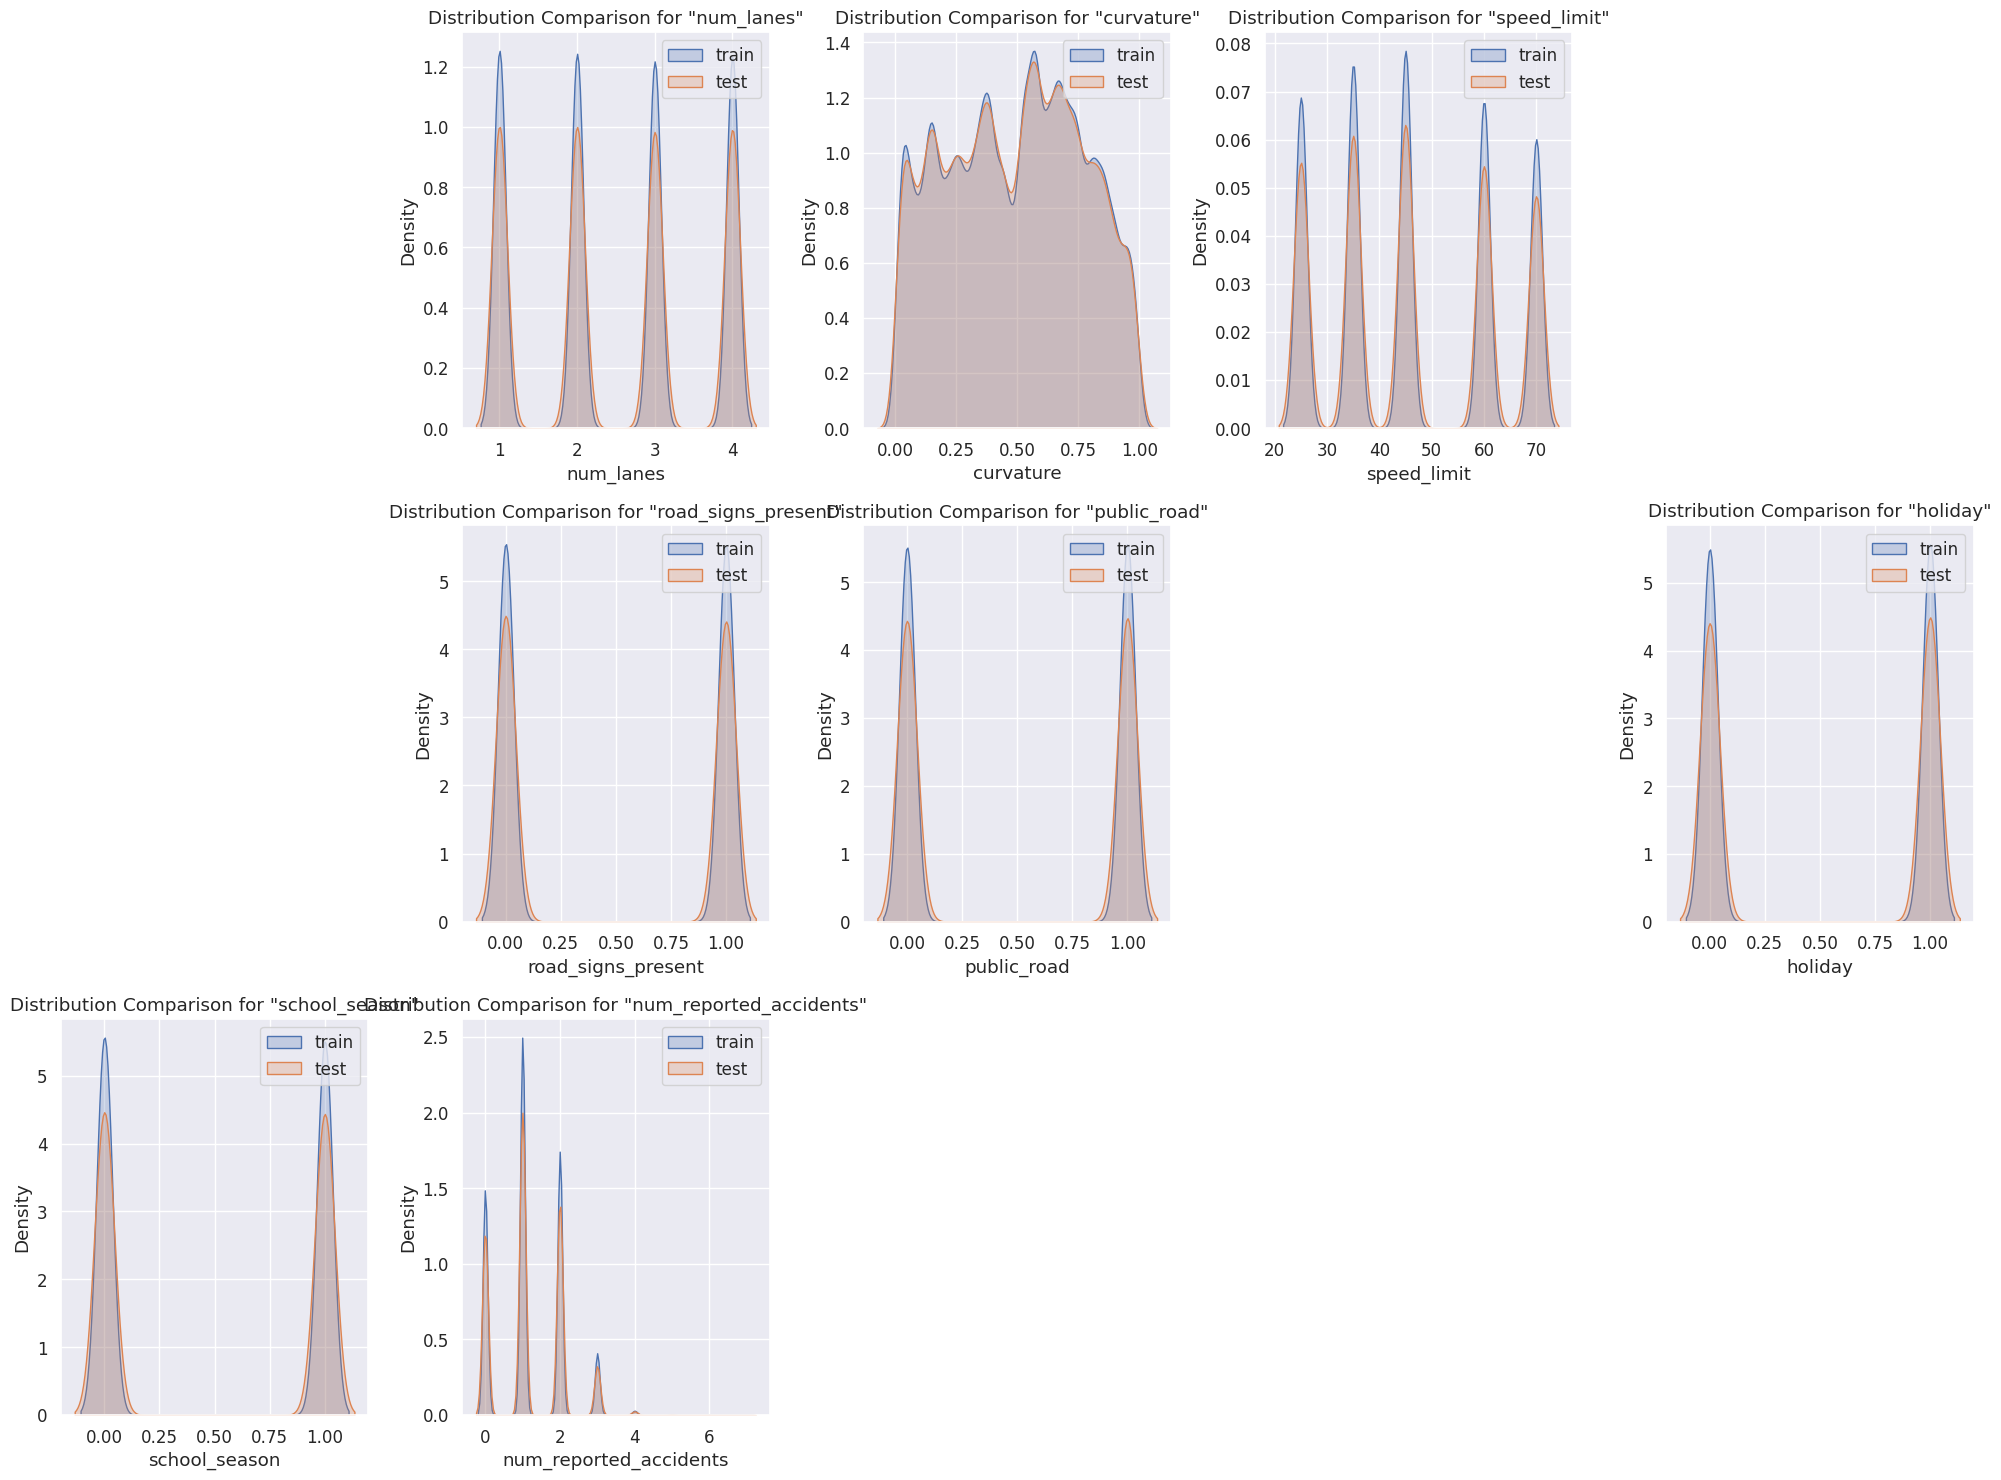

In [8]:
plt.figure(figsize=(20,15))
for i,column in enumerate(train.columns):
  if column in test.columns:
       if pd.api.types.is_numeric_dtype(train[column]):
        plt.subplot(3,5,i+1)
        sns.kdeplot(train[column], label='train', fill=True)
        sns.kdeplot(test[column], label='test', fill=True)
        plt.title(f'Distribution Comparison for "{column}"')
        plt.legend()
plt.tight_layout()
plt.show()

<h4 style="color:orange;font-weight:bold;">These graphs and tables suggest that there is no significant difference in the overall characteristics of the train and test data.</h4>

In [9]:
target="accident_risk"

features=test.columns.to_list()
numerical_features=train[features].select_dtypes(include=np.number).columns.to_list()
categorical_features=train[features].select_dtypes(exclude=np.number).columns.to_list()

In [10]:
features

['road_type',
 'num_lanes',
 'curvature',
 'speed_limit',
 'lighting',
 'weather',
 'road_signs_present',
 'public_road',
 'time_of_day',
 'holiday',
 'school_season',
 'num_reported_accidents']

In [11]:
numerical_features

['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']

In [12]:
categorical_features

['road_type',
 'lighting',
 'weather',
 'road_signs_present',
 'public_road',
 'time_of_day',
 'holiday',
 'school_season']

## <font color="green"> 1. Check for missing values,duplicating</font>

In [13]:
train.isnull().sum()

road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

In [14]:
#Removing duplicate rows is done to prevent bias and maintain reliability.
num_duplicates=train.duplicated().sum()
print(f"Number of duplicate rows in train: {num_duplicates}")
if num_duplicates > 0:
    train=train.drop_duplicates()

Number of duplicate rows in train: 656


# <font color="blue">3. Exploratory Data Analysis (EDA)</font>

## Acknowledgements
### EDA (Inspired by @Dibya S. Barik)

The following Exploratory Data Analysis (EDA) was heavily inspired by the work of @Dibya S. Barik in their notebook, "[0.05567] Road Accident Risk Prediction|Baseline". I highly recommend checking it out.

## <font color="green"> 1. Univariate Analysis</font>

### <font color="blue"> 1. Numerical_feature</font>

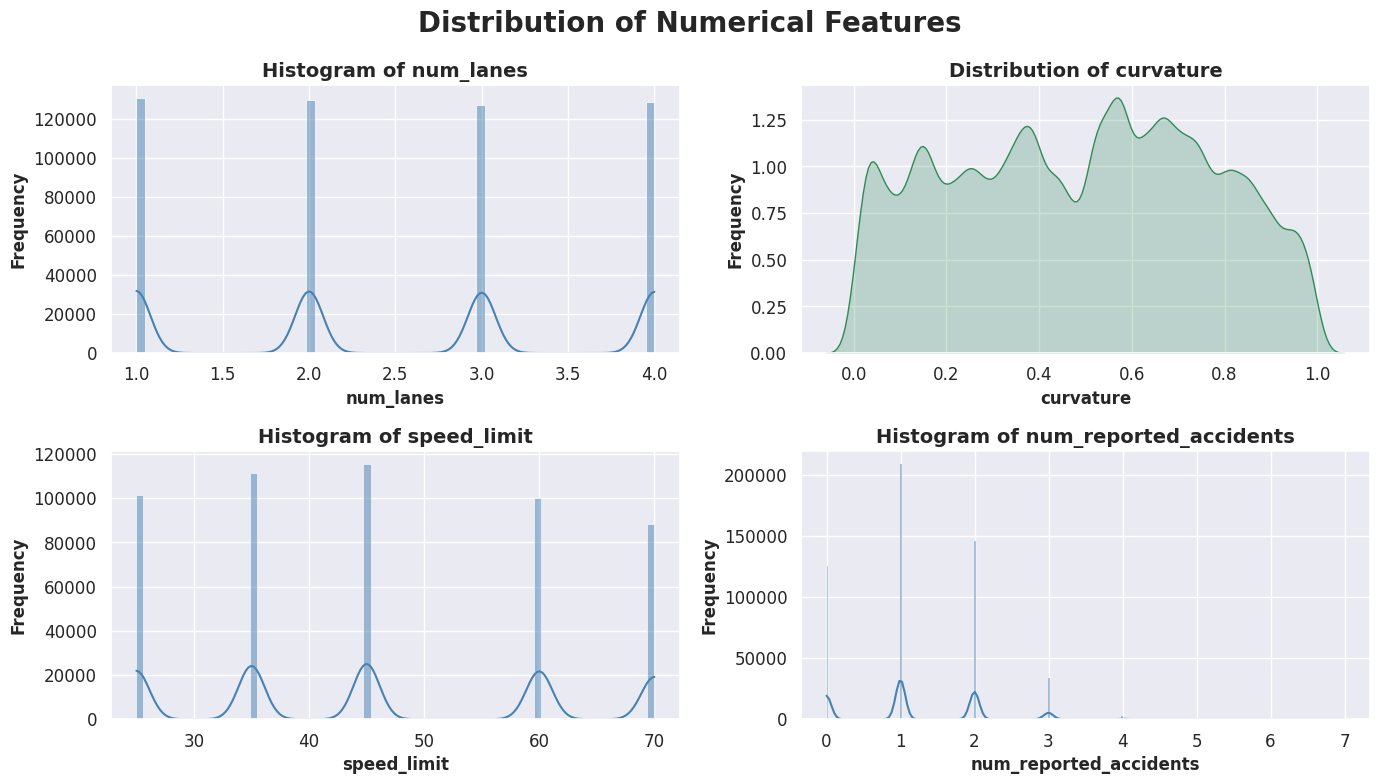

In [15]:
fig, axes=plt.subplots(2,2,figsize=(14,8))
#Converting a two-dimensional array into a one-dimensional array makes it easier to handle with a for loop.
axes=axes.flatten()

for i,feature in enumerate(numerical_features):
  if pd.api.types.is_integer_dtype(train[feature]):
    #Display a kernel density estimation (KDE) curve overlaid on the histogram to smoothly represent the shape of the distribution.
    sns.histplot(data=train,x=feature,ax=axes[i],kde=True,color='steelblue')
    axes[i].set_title(f"Histogram of {feature}",fontweight="bold",fontsize=14)
  else:
    sns.kdeplot(data=train,x=feature,ax=axes[i],fill=True,color='seagreen')
    axes[i].set_title(f"Distribution of {feature}",fontweight="bold",fontsize=14)
  axes[i].set_xlabel(feature,fontsize=12,fontweight="bold")
  axes[i].set_ylabel("Frequency",fontsize=12,fontweight="bold")
plt.suptitle("Distribution of Numerical Features",fontsize=20,fontweight="bold")
plt.tight_layout()
plt.show()

<h4 style="color:orange;font-weight:bold;">In the three graphs other than num_reported_accident, we can see that the values are equally distributed. However, in num_reported_accident, we can see that the values follow the order 1 > 2 > 3 > 4.</h4>

### <font color="blue"> 2. Categorical_feature</font>

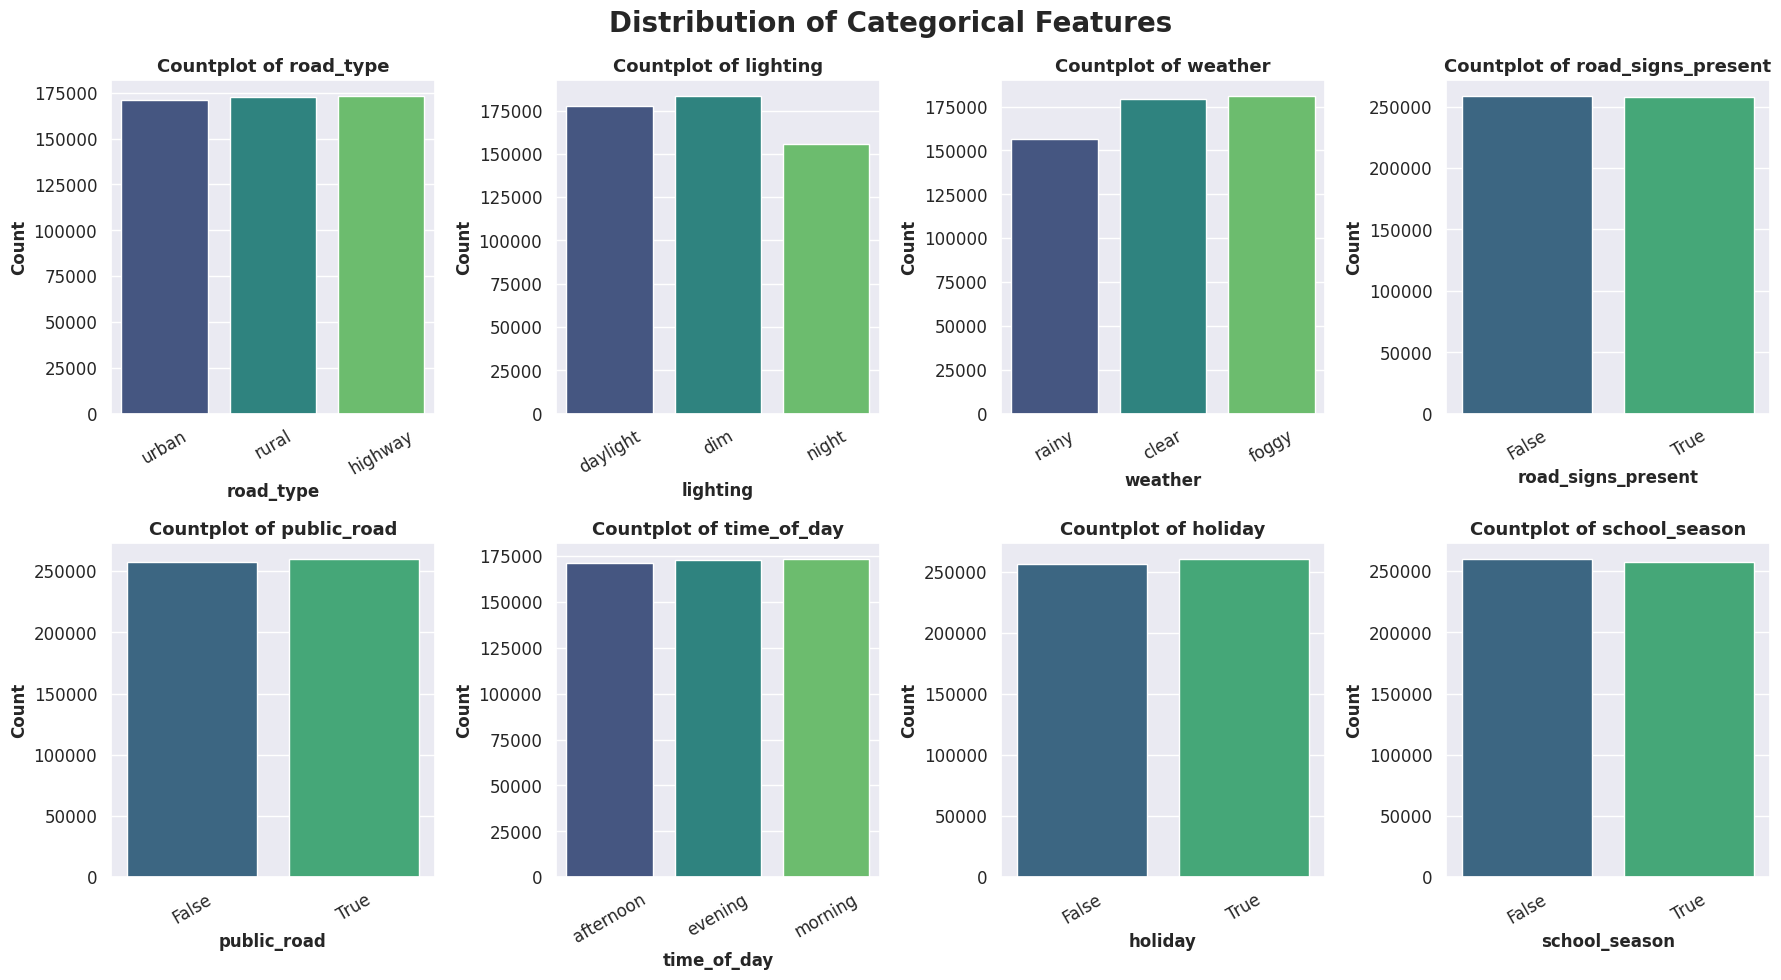

In [16]:
fig, axes=plt.subplots(2,4,figsize=(18,10))
axes=axes.flatten()

for i,feature in enumerate(categorical_features):
  sns.countplot(data=train,x=feature,ax=axes[i],palette='viridis')
  axes[i].set_title(f"Countplot of {feature}",fontweight="bold",fontsize=13)
  axes[i].set_xlabel(feature,fontsize=12,fontweight="bold")
  axes[i].set_ylabel("Count",fontsize=12,fontweight="bold")
  axes[i].tick_params(axis='x',rotation=30)
plt.suptitle("Distribution of Categorical Features",fontsize=20,fontweight="bold")
plt.tight_layout()
plt.show()

<h4 style="color:orange;font-weight:bold;">From these graphs, it can be seen that the quantities for each category are nearly equal.</h4>

## <font color="green"> 2. Target Analysis</font>

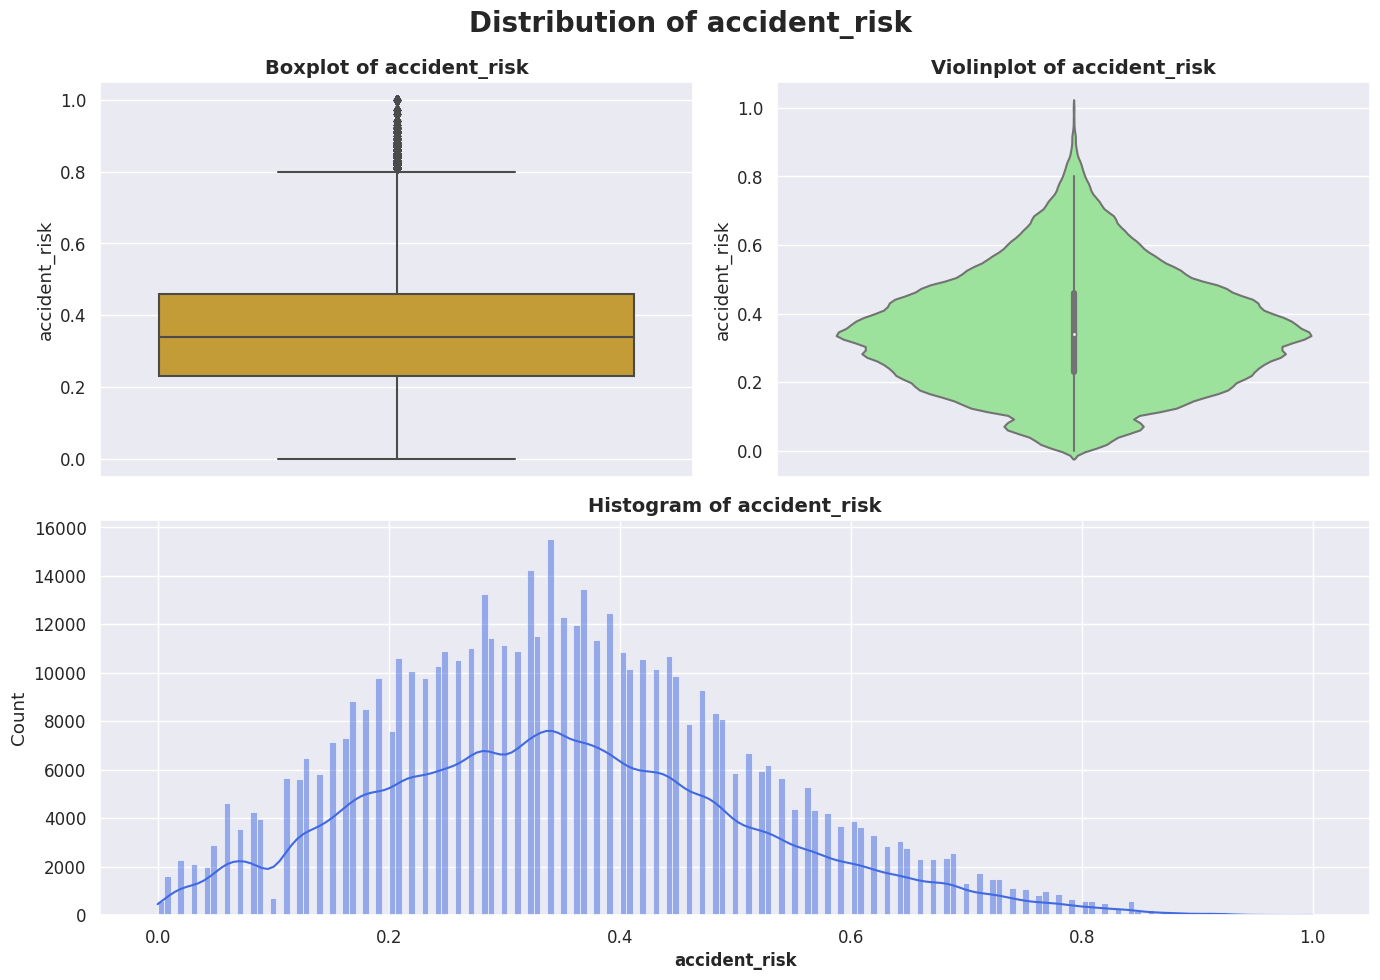

In [17]:
fig,axes=plt.subplot_mosaic([['A','B'],['C','C']],figsize=(14,10))
sns.boxplot(y=target,data=train,ax=axes['A'],color='goldenrod')
axes['A'].set_title(f"Boxplot of {target}",fontweight="bold",fontsize=14)
sns.violinplot(y=target,data=train,ax=axes['B'],color='lightgreen')
axes['B'].set_title(f"Violinplot of {target}",fontweight="bold",fontsize=14)
sns.histplot(train[target],kde=True,ax=axes['C'],color='royalblue')
axes['C'].set_title(f"Histogram of {target}",fontweight="bold",fontsize=14)
axes['C'].set_xlabel(target,fontsize=12,fontweight="bold")
plt.suptitle(f"Distribution of {target}",fontsize=20,fontweight="bold")
plt.tight_layout()
plt.show()

<h4 style="color:orange;font-weight:bold;">From this, we can see that the target variable accident_risk exhibits a right-skewed distribution.</h4>

## <font color="green"> 3. Bivariate Analysis</font>

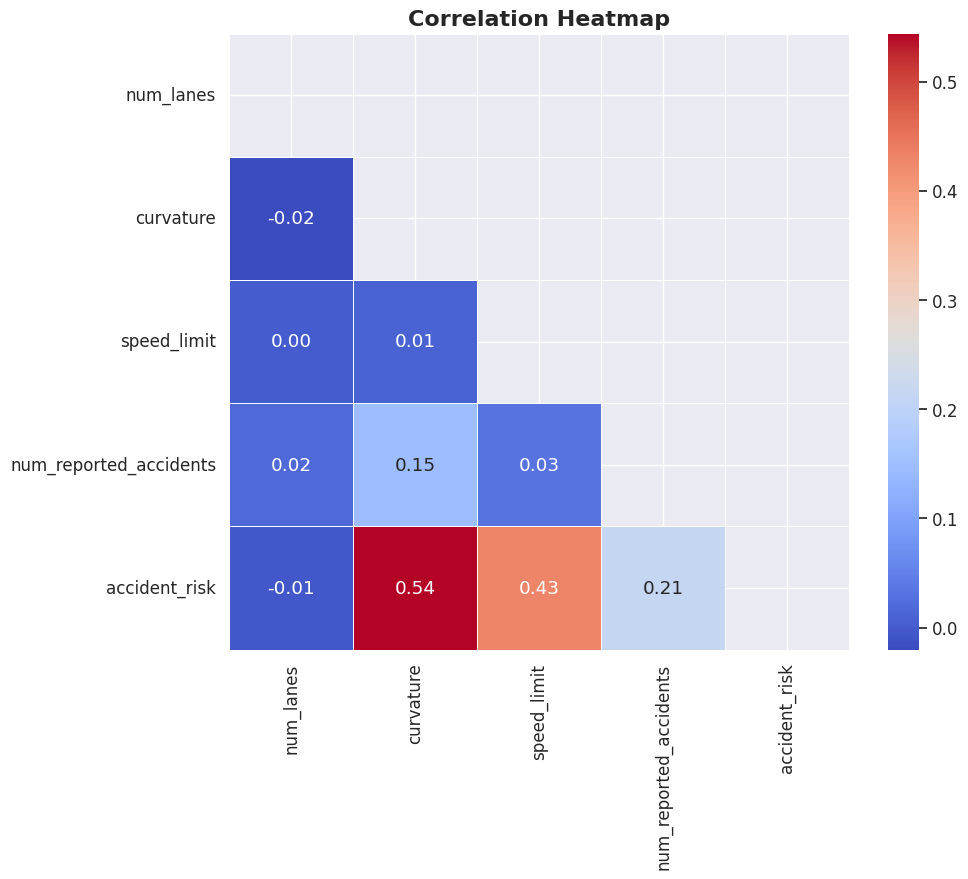

In [18]:
corr=train[numerical_features+[target]].corr()
#This is used to specify “what to display and what to hide” when drawing the heatmap later.
mask=np.triu(np.ones_like(corr,dtype=bool))

plt.figure(figsize=(10,8))
#The top half that is set to True by the mask is hidden.
sns.heatmap(corr,mask=mask,annot=True,fmt=".2f",cmap="coolwarm",linewidths=0.5)
plt.title("Correlation Heatmap",fontweight="bold",fontsize=16)
plt.show()

<h4 style="color:orange;font-weight:bold;">From this, we can see that the correlation between curvature, speed_limit and accident_risk is relatively high.</h4>

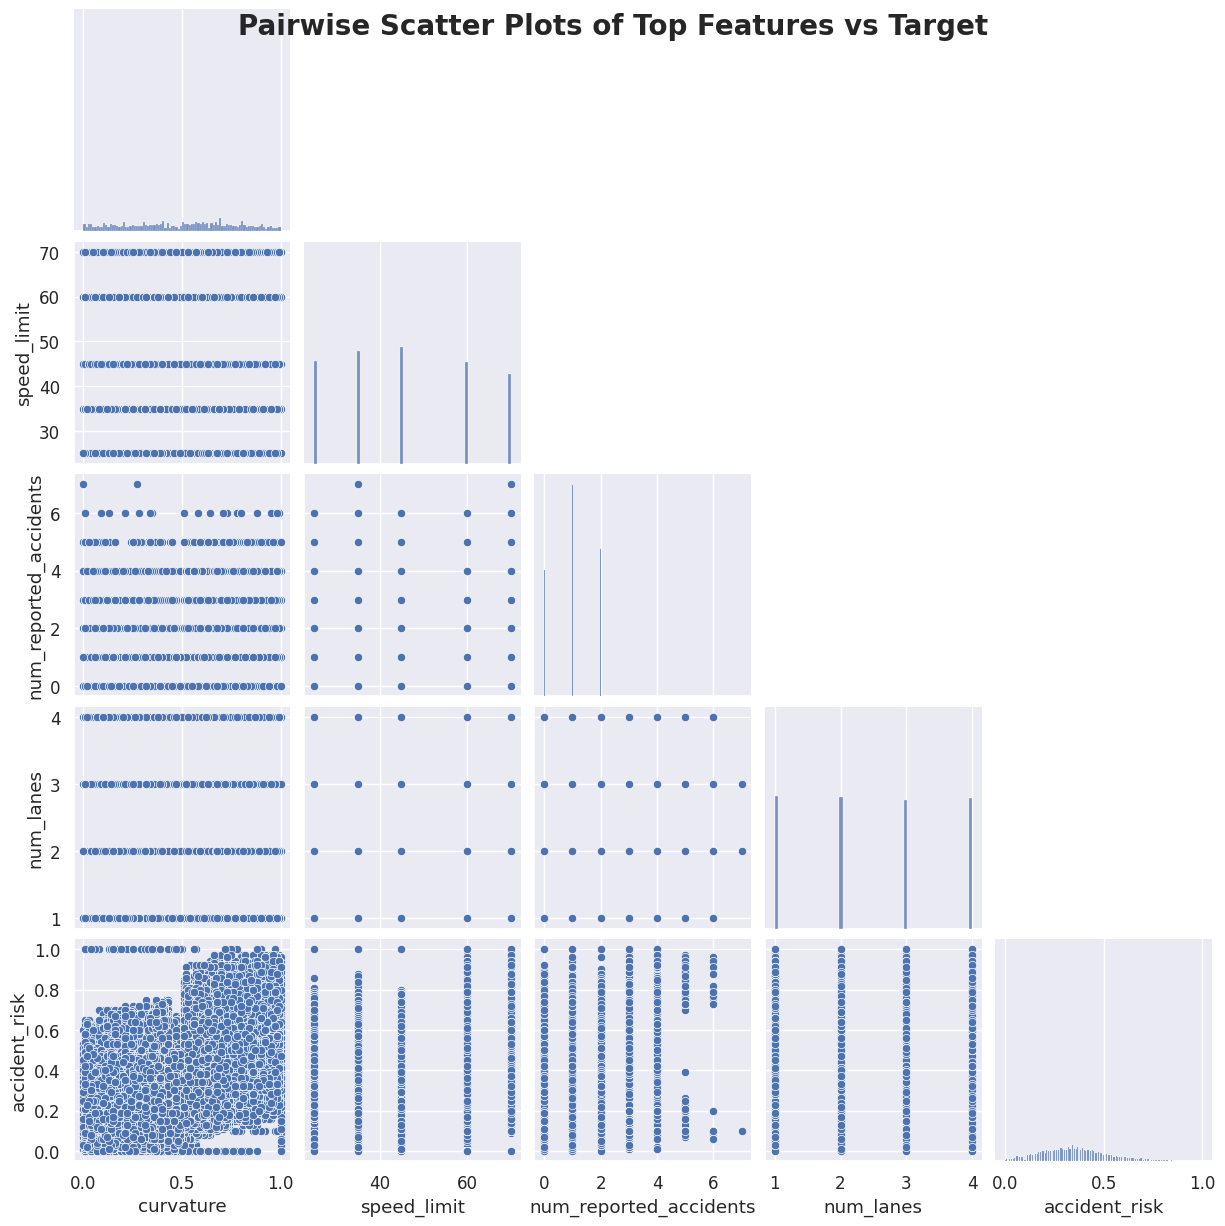

In [19]:
top_corr_features=corr[target].abs().sort_values(ascending=False)[1:5].index.tolist()
sns.pairplot(train,vars=top_corr_features+[target],kind='scatter',corner=True)
plt.suptitle("Pairwise Scatter Plots of Top Features vs Target",fontsize=20,fontweight="bold")
plt.show()

<h4 style="color:orange;font-weight:bold;">These graphs do not visually show much correlation between the two features.</h4>

<h4 style="color:orange;font-weight:bold;">We consider that accident risk varies depending on road type and lighting.</h4>

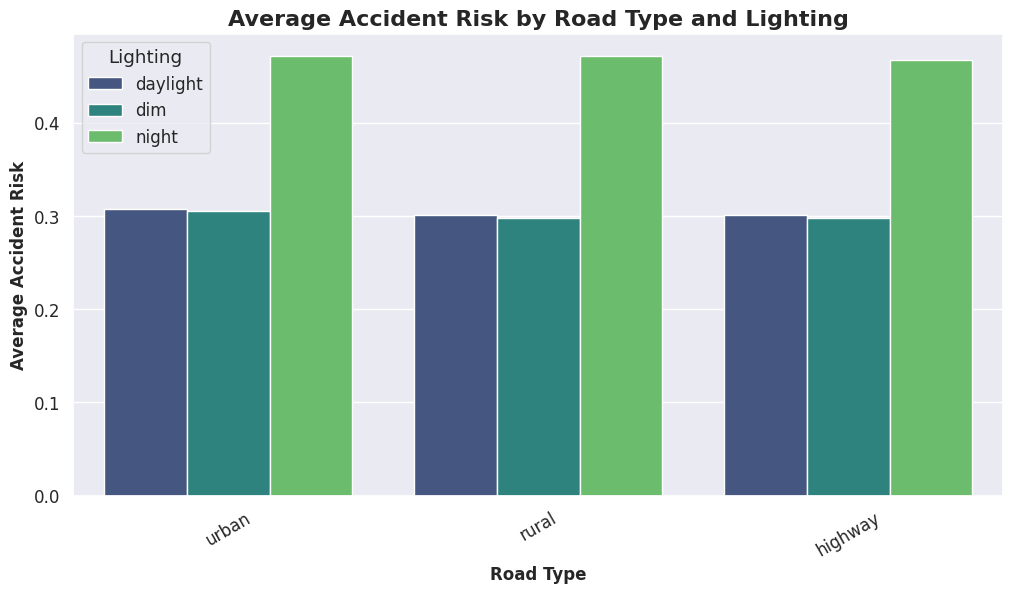

In [20]:
plt.figure(figsize=(12,6))
sns.barplot(x='road_type',y=target,data=train,hue='lighting',ci=None,palette='viridis')
plt.title("Average Accident Risk by Road Type and Lighting",fontweight="bold",fontsize=16)
plt.xlabel("Road Type",fontsize=12,fontweight="bold")
plt.ylabel("Average Accident Risk",fontsize=12,fontweight="bold")
plt.xticks(rotation=30)
plt.legend(title="Lighting")
plt.show()

<h4 style="color:orange;font-weight:bold;">We believe that accident risk changes depending on holidays and school seasons.</h4>

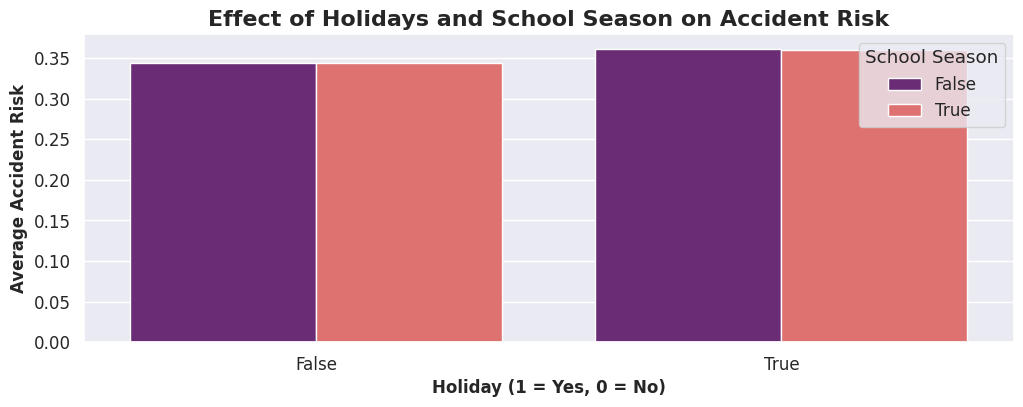

In [21]:
plt.figure(figsize=(12, 4))
sns.barplot(x='holiday', y=target, hue='school_season', data=train, ci=None, palette='magma')
plt.title("Effect of Holidays and School Season on Accident Risk", fontsize=16, fontweight='bold')
plt.xlabel("Holiday (1 = Yes, 0 = No)", fontsize=12, fontweight='bold')
plt.ylabel("Average Accident Risk", fontsize=12, fontweight='bold')
plt.legend(title="School Season")
plt.show()

<h4 style="color:orange;font-weight:bold;">We consider that accident risk changes depending on lighting and weather.</h4>

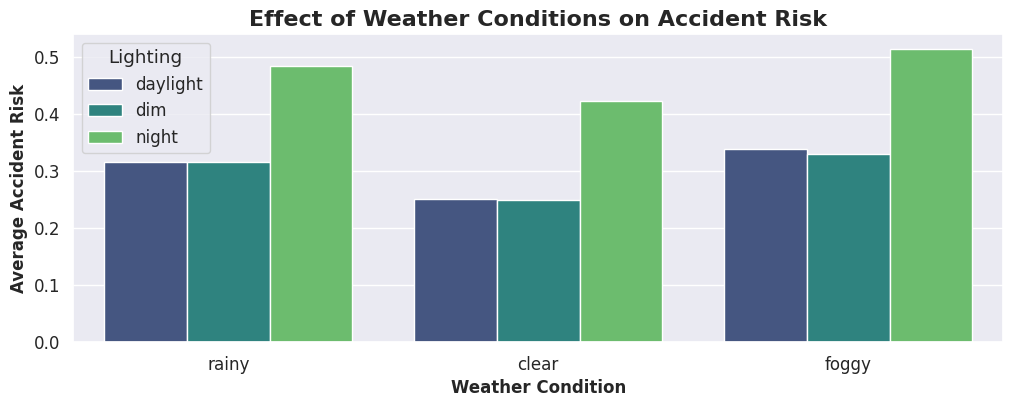

In [22]:
plt.figure(figsize=(12, 4))
sns.barplot(x='weather', y=target, hue='lighting', data=train, ci=None, palette='viridis')
plt.title("Effect of Weather Conditions on Accident Risk", fontsize=16, fontweight='bold')
plt.xlabel("Weather Condition", fontsize=12, fontweight='bold')
plt.ylabel("Average Accident Risk", fontsize=12, fontweight='bold')
plt.legend(title="Lighting")
plt.show()

<h4 style="color:orange;font-weight:bold;">We consider that accident risk varies depending on lighting, weather, and time of day.</h4>

<Figure size 1600x500 with 0 Axes>

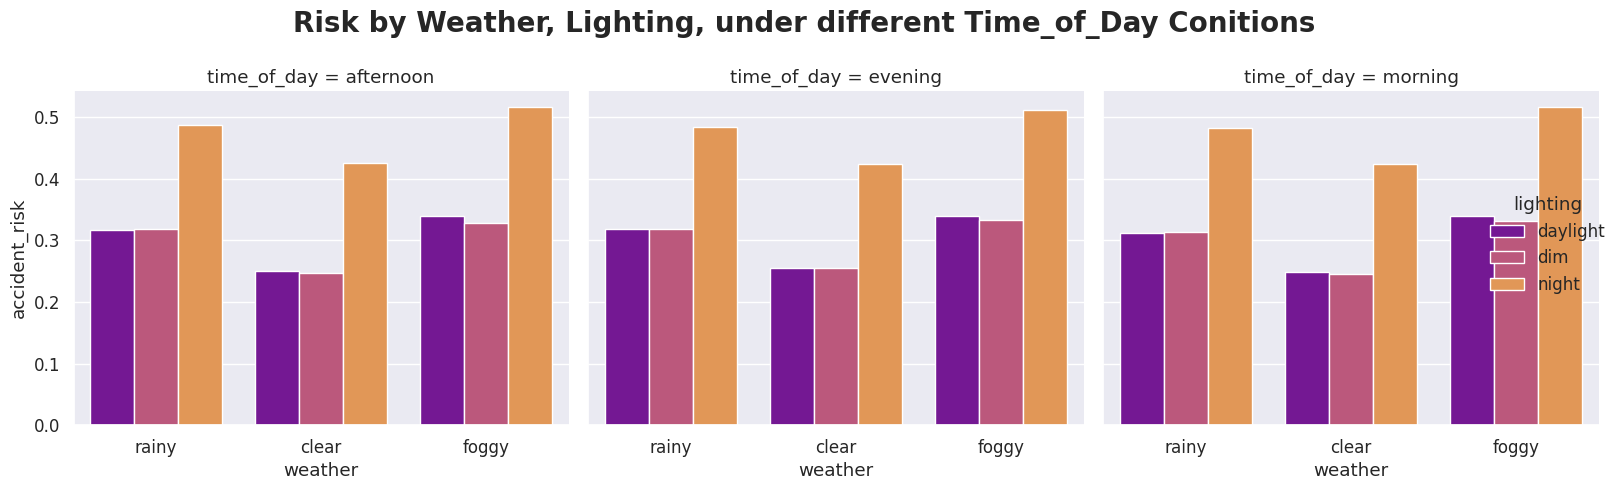

In [23]:
plt.figure(figsize=(16, 5))
sns.catplot(x='weather',y=target,hue='lighting',col='time_of_day',data=train,kind='bar',ci=None,palette='plasma')
plt.suptitle("Risk by Weather, Lighting, under different Time_of_Day Conitions",fontsize=20,fontweight="bold")
plt.tight_layout()
plt.show()

<h4 style="color:orange;font-weight:bold;">This graph shows that risk increases during rainy and foggy conditions. Focusing on lightning, risk rises significantly at night compared to the other two conditions.</h4>

<Figure size 1600x500 with 0 Axes>

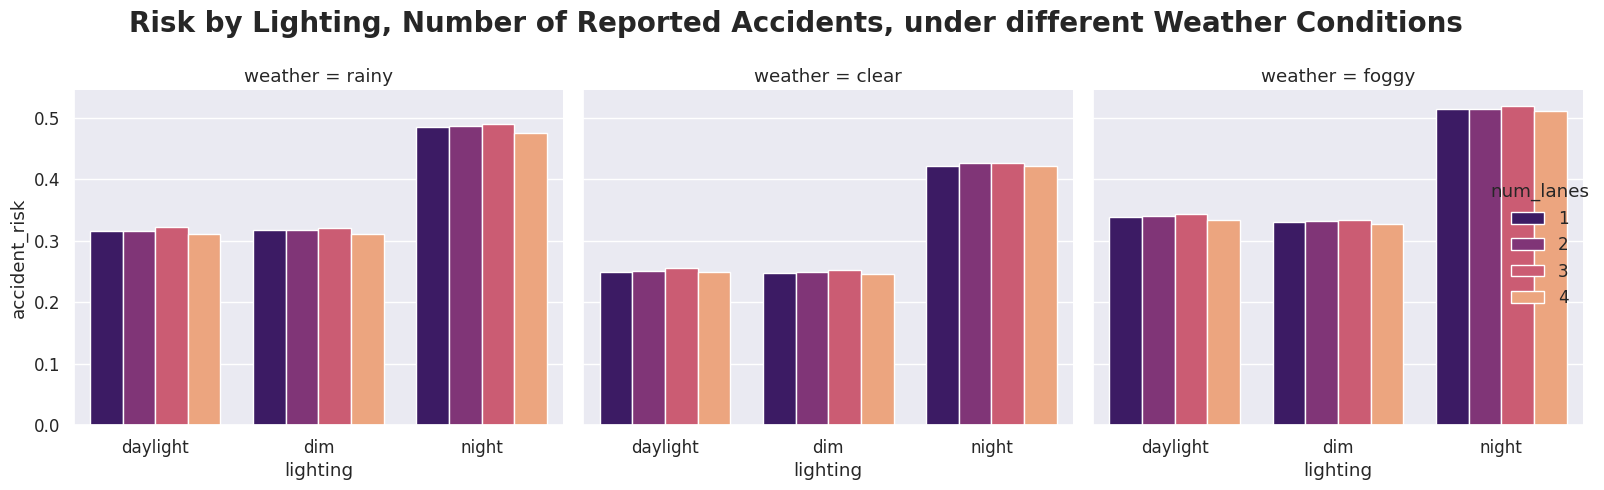

In [24]:
plt.figure(figsize=(16, 5))
sns.catplot(x='lighting',y=target,hue='num_lanes',col='weather',data=train,kind='bar',ci=None,palette='magma')
plt.suptitle("Risk by Lighting, Number of Reported Accidents, under different Weather Conditions",fontsize=20,fontweight="bold")
plt.tight_layout()
plt.show()

<h4 style="color:orange;font-weight:bold;">Similarly, this graph shows that risk increases dramatically at night, while the difference in lane count is not as significant.</h4>

<Figure size 1600x500 with 0 Axes>

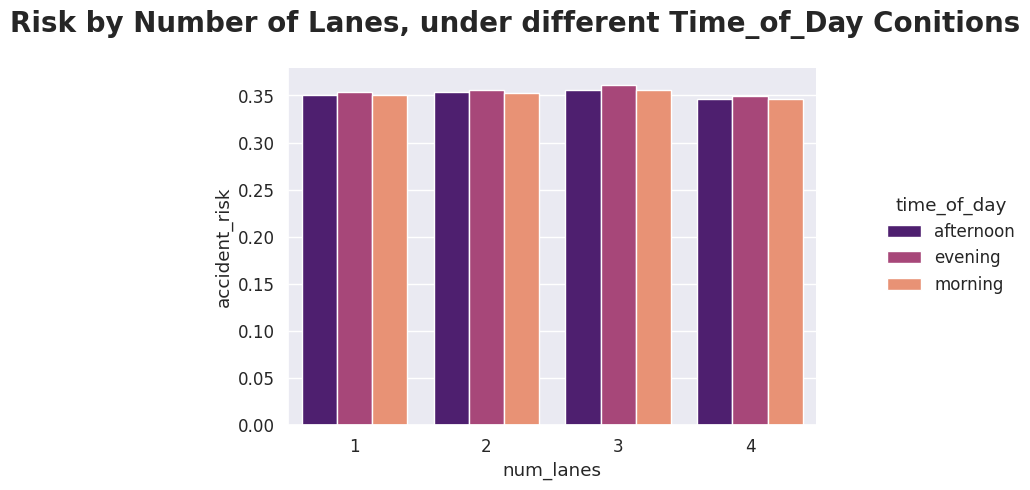

In [25]:
plt.figure(figsize=(16, 5))
sns.catplot(x='num_lanes',y=target,hue='time_of_day',data=train,kind='bar',ci=None,palette='magma')
plt.suptitle("Risk by Number of Lanes, under different Time_of_Day Conitions",fontsize=20,fontweight="bold")
plt.tight_layout()
plt.show()

<h4 style="color:orange;font-weight:bold;">From this graph and the previous one, we see that the risk increases significantly under nighttime lighting. However, when categorized by evening, morning, and afternoon, the risk only rises slightly during evening.</h4>

<Figure size 1600x500 with 0 Axes>

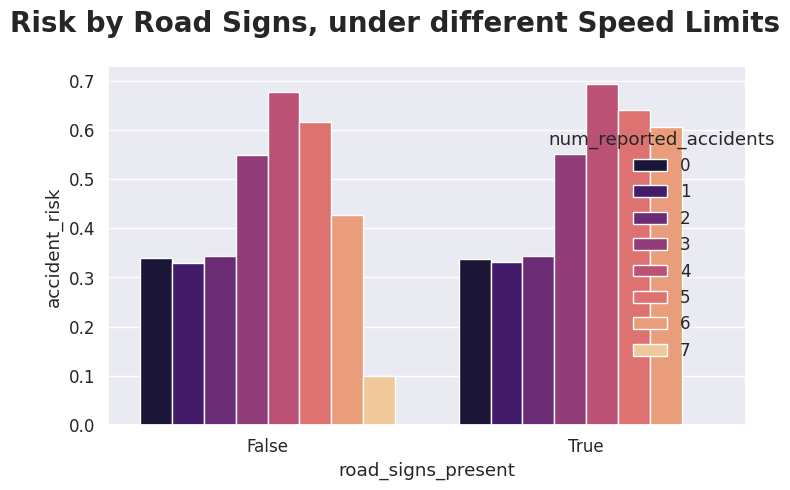

In [26]:
plt.figure(figsize=(16, 5))
sns.catplot(x='road_signs_present',y=target,hue='num_reported_accidents',data=train,kind='bar',ci=None,palette='magma')
plt.suptitle("Risk by Road Signs, under different Speed Limits",fontsize=20,fontweight="bold")
plt.tight_layout()
plt.show()

<h4 style="color:orange;font-weight:bold;">This graph shows that the risk increases sharply when the number of reported accidents reaches 3 or more. This simply indicates that locations where accidents are likely to occur become accident-prone areas. On the other hand, focusing on the presence of road signs reveals that locations marked as True have a higher risk when the number of reported accidents is between 4 and 6.</h4>

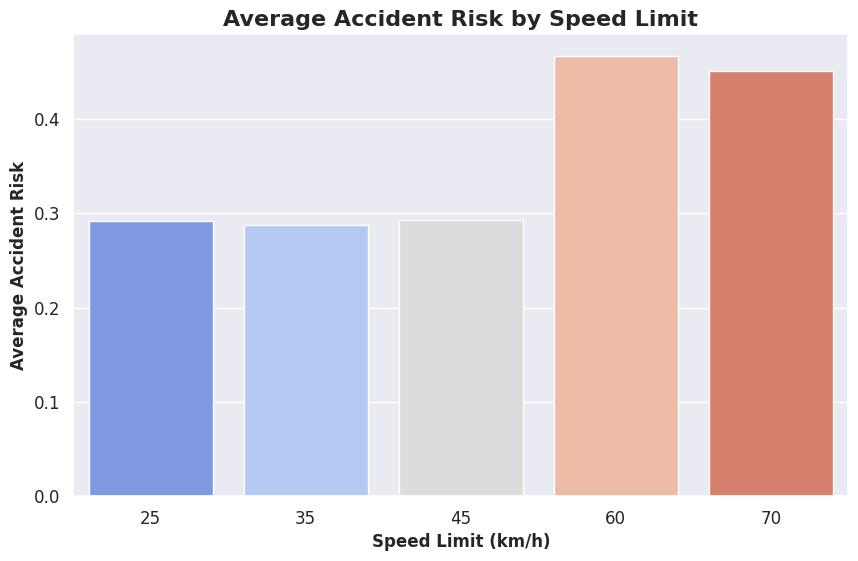

In [27]:
plt.figure(figsize=(10, 6))
sns.barplot(x='speed_limit', y=target, data=train, ci=None, palette='coolwarm')
plt.title("Average Accident Risk by Speed Limit", fontsize=16, fontweight='bold')
plt.xlabel("Speed Limit (km/h)", fontsize=12, fontweight='bold')
plt.ylabel("Average Accident Risk", fontsize=12, fontweight='bold')
plt.show()

<h4 style="color:orange;font-weight:bold;">This graph shows that risk suddenly spikes when the speed limit exceeds 60 km/h.</h4>

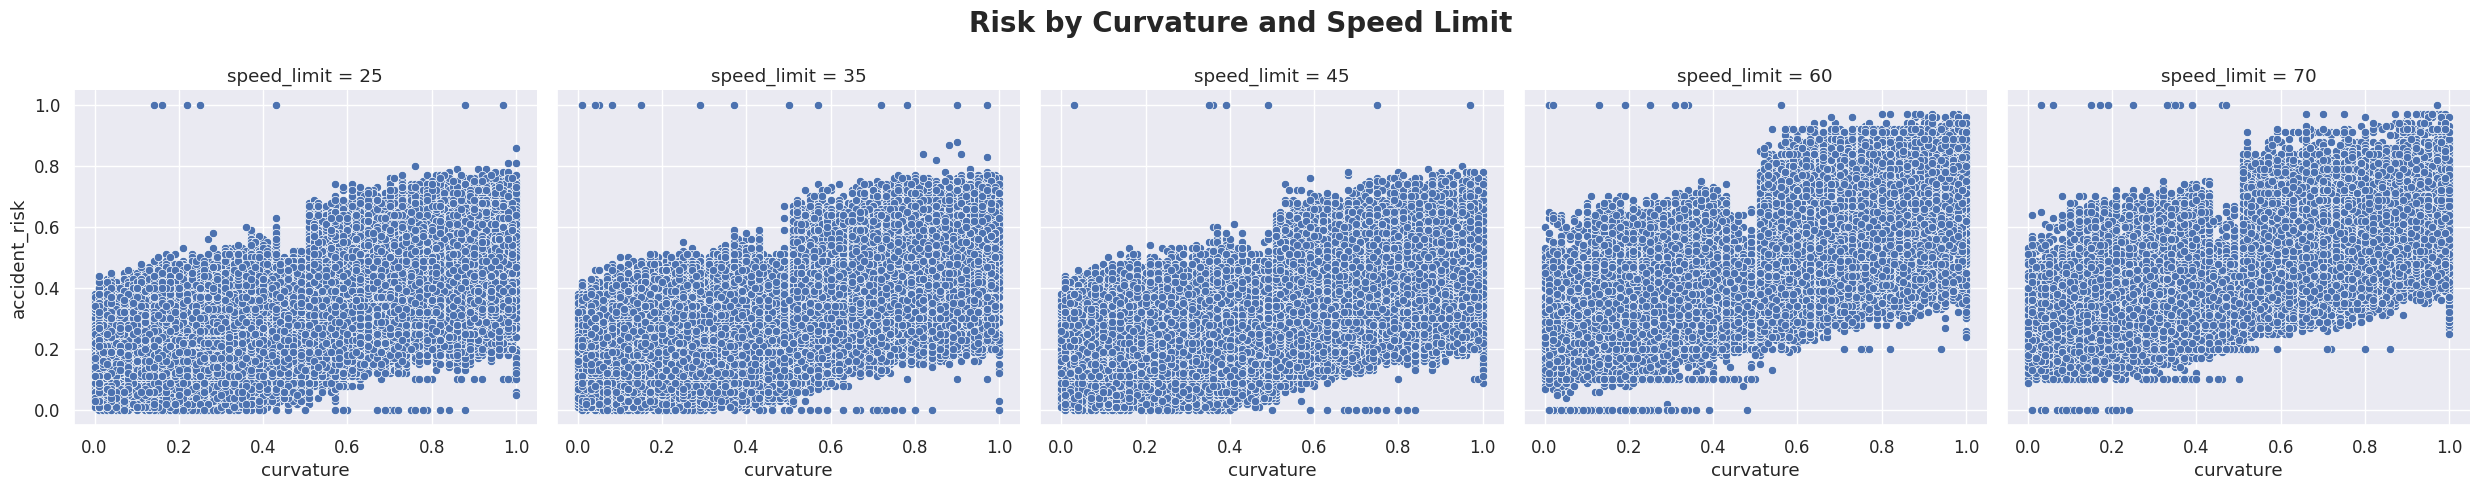

In [28]:
sns.relplot(x='curvature',y=target,col='speed_limit',data=train,kind='scatter',palette='viridis')
plt.suptitle("Risk by Curvature and Speed Limit",fontsize=20,fontweight="bold")
plt.tight_layout()
plt.show()

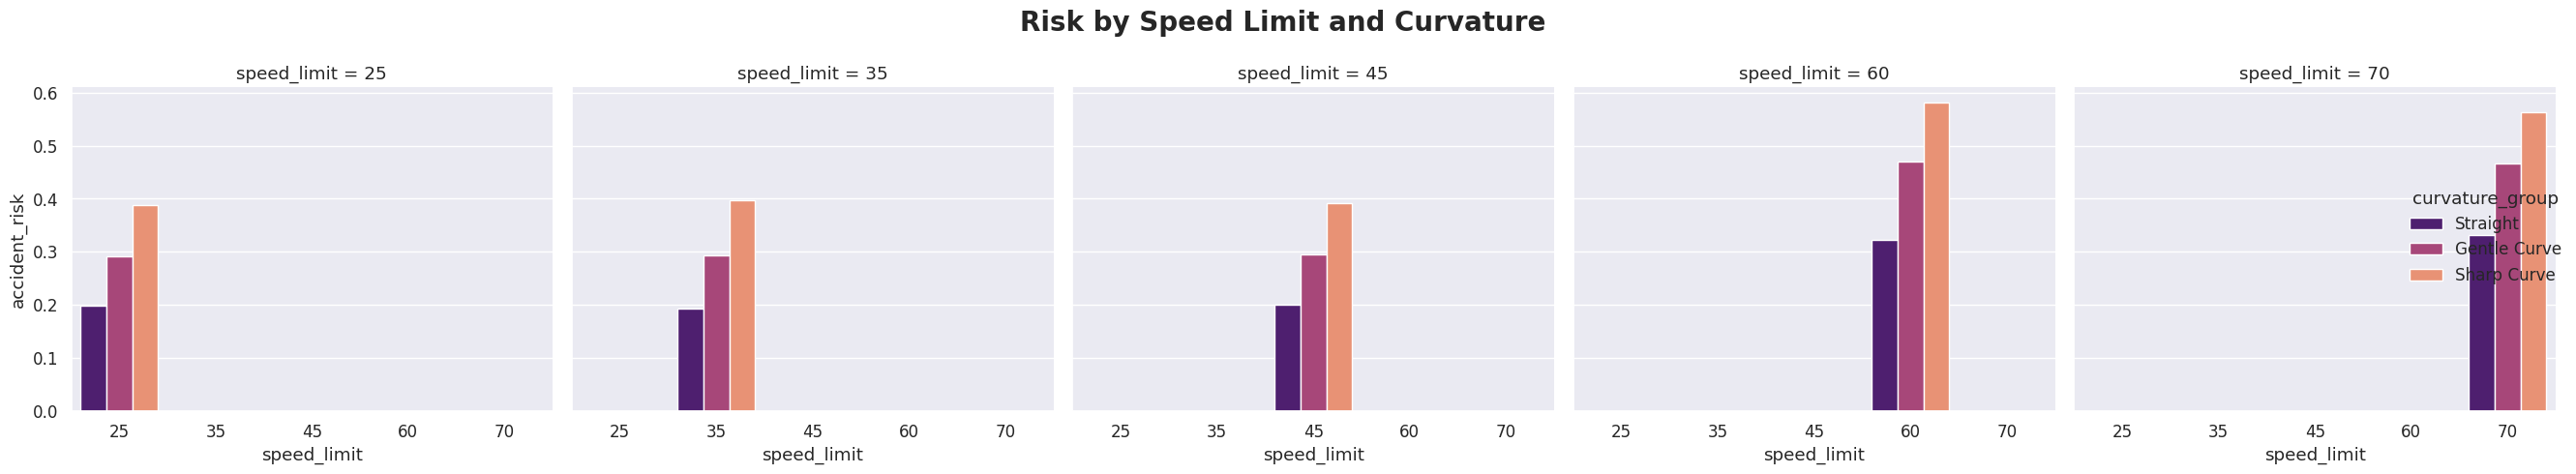

In [29]:
train['curvature_group']=pd.cut(train['curvature'],bins=3,labels=['Straight','Gentle Curve','Sharp Curve'])
sns.catplot(x='speed_limit',y=target,hue='curvature_group',col='speed_limit',data=train,kind='bar',ci=None,palette='magma')
plt.suptitle("Risk by Speed Limit and Curvature",fontsize=20,fontweight="bold")
plt.tight_layout()
plt.show()

<h4 style="color:orange;font-weight:bold;">As the speed limit increases, risk increases. Looking at curvature, we see that risk increases as sharpness increases at any given speed.</h4>

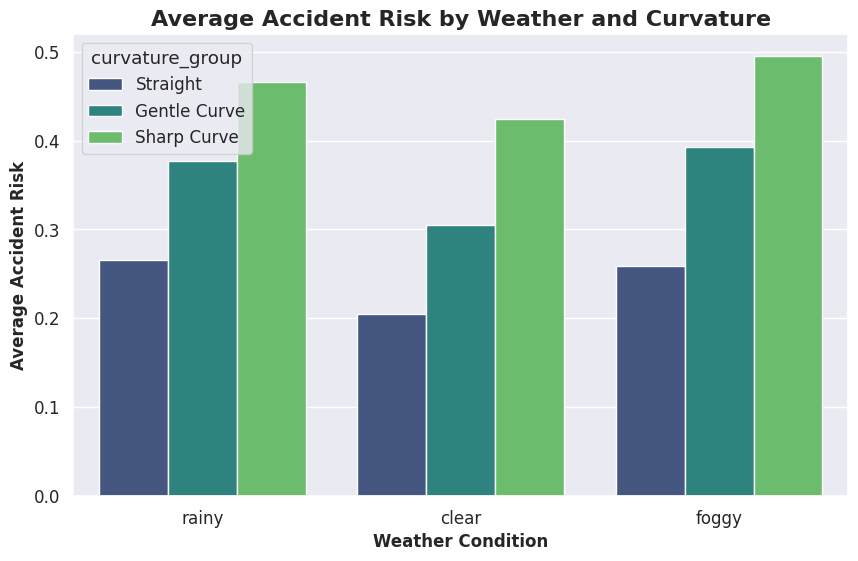

In [30]:
plt.figure(figsize=(10, 6))
sns.barplot(x='weather', y=target, hue='curvature_group',data=train, ci=None, palette='viridis')
plt.title("Average Accident Risk by Weather and Curvature", fontsize=16, fontweight='bold')
plt.xlabel("Weather Condition", fontsize=12, fontweight='bold')
plt.ylabel("Average Accident Risk", fontsize=12, fontweight='bold')
plt.show()

<h4 style="color:orange;font-weight:bold;">Similarly, rainy and foggy conditions pose significant risks, and within those, sharp curves present an even greater risk.</h4>

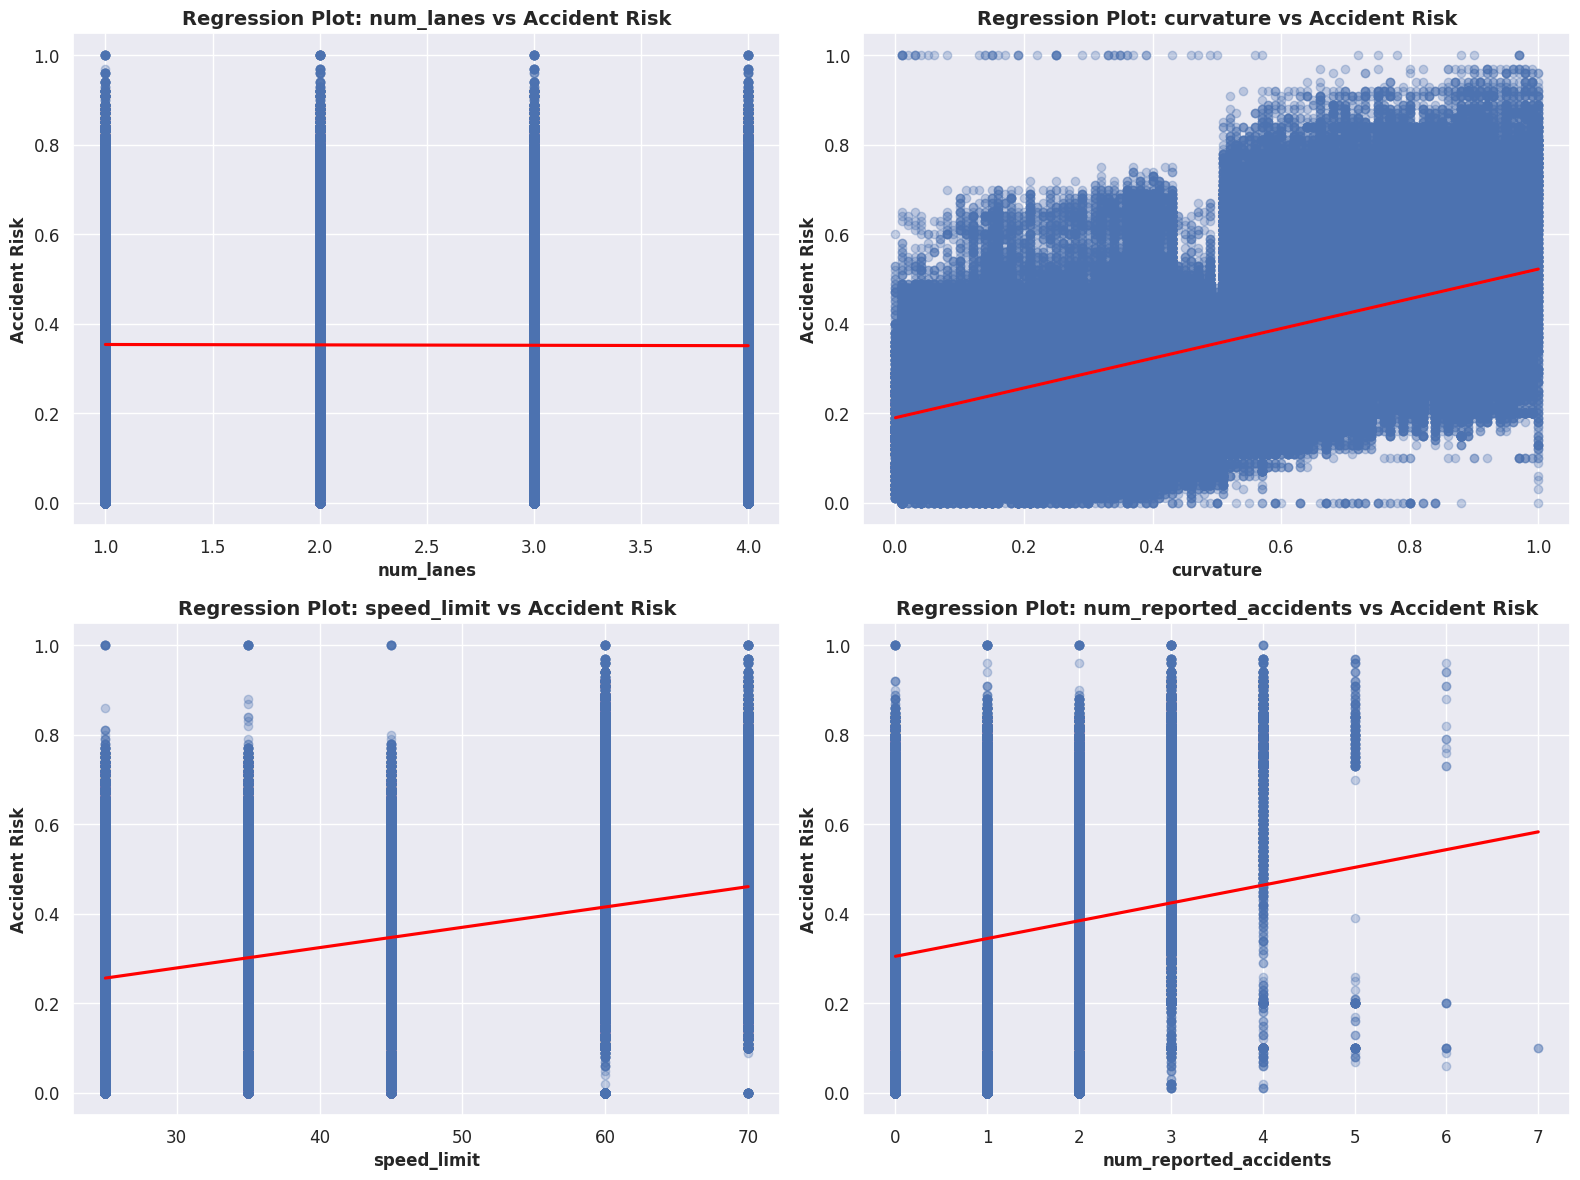

In [31]:
plt.figure(figsize=(16, 12))

for i, feature in enumerate(numerical_features):
    plt.subplot(2, 2, i+1)
    sns.regplot(x=feature, y='accident_risk', data=train, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    plt.title(f"Regression Plot: {feature} vs Accident Risk", fontsize=14, fontweight='bold')
    plt.xlabel(feature, fontsize=12, fontweight='bold')
    plt.ylabel("Accident Risk", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# <font color="blue"> 4. Cross-Validation</font>

In [32]:
#This is a function that performs cross-validation using the K-Fold method, enabling model training, evaluation, and prediction on test data all at once.
def model_trainer(model, X, y, test=None, nsplits=5, random_state=42, log_target=False):

  kfold = KFold(n_splits=nsplits, shuffle=True, random_state=random_state)
  y_array = y.to_numpy() if isinstance(y, pd.Series) else y.copy()
  test_array = test.to_numpy() if isinstance(test, pd.DataFrame) else test

  if log_target:
    y_array = np.log1p(y_array)

  oof_train_preds = np.zeros(len(y_array))

  if test_array is not None:
    oof_test_preds = np.zeros(len(test_array))

  oof_rmse = []
  oof_r2 = []

  for fold, (train_idx, val_idx) in enumerate(kfold.split(X), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y_array[train_idx], y_array[val_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    y_val_orig = np.expm1(y_val) if log_target else y_val
    y_pred_orig = np.expm1(y_pred) if log_target else y_pred

    rmse = np.sqrt(mean_squared_error(y_val_orig, y_pred_orig))
    r2 = r2_score(y_val_orig, y_pred_orig)

    oof_rmse.append(rmse)
    oof_r2.append(r2)
    oof_train_preds[val_idx] = y_pred

    if test is not None:
      test_pred = model.predict(test)
      test_pred_orig = np.expm1(test_pred) if log_target else test_pred
      oof_test_preds += test_pred_orig / nsplits

    print(f"Fold {fold} → RMSE: {rmse:.4f}, R2: {r2:.4f}")

  print(f"\nAverage Fold RMSE Score: {np.mean(oof_rmse):.4f} ± {np.std(oof_rmse):.4f}")
  print(f"\nAverage Fold R2 Score: {np.mean(oof_r2):.4f} ± {np.std(oof_r2):.4f}")

  if test_array is not None:
    oof_train_preds_orig = np.expm1(oof_train_preds) if log_target else oof_train_preds
    return oof_train_preds_orig, oof_test_preds

  oof_train_preds_orig = np.expm1(oof_train_preds) if log_target else oof_train_preds
  return oof_train_preds_orig

# <font color="blue">5. Preprocessing, Feature Engineering, Model Training</font>

In [33]:
#This is a script that executes the entire workflow from machine learning preprocessing to feature engineering and model training.

X=train.drop(target,axis=1)
y=train[target]
comb=pd.concat([X,test],axis=0)
#To use the same mean and standard deviation for StandardScaler and the same category list for OneHotEncoder across both training and test data.

time_mapping = {'morning': 0, 'afternoon': 1, 'evening': 2, 'night': 3}
comb['time_of_day'] = comb['time_of_day'].map(time_mapping)
cycle_length = 4
comb['time_sin'] = np.sin(2 * np.pi * comb['time_of_day'] / cycle_length)
comb['time_cos'] = np.cos(2 * np.pi * comb['time_of_day'] / cycle_length)
comb = comb.drop(columns=['time_of_day'])

numerical_features = comb.select_dtypes(include=np.number).columns.tolist()
categorical_features = comb.select_dtypes(exclude=['number', 'datetime']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

comb_preprocessed_np = preprocessor.fit_transform(comb)

#A function to remove prefixes like ‘num__’ or ‘cat__’ from column names
def clean_col_names(names):
    cleaned_names = []
    for name in names:
        if name.startswith('num__') or name.startswith('cat__'):
            cleaned_names.append(name[5:])
        else:
            cleaned_names.append(name)
    return cleaned_names

feature_names = clean_col_names(preprocessor.get_feature_names_out())
comb_preprocessed = pd.DataFrame(comb_preprocessed_np, index=comb.index, columns=feature_names)

#Performed feature engineering from EDA. Conditions such as curvature, speed (especially above 60 km/h), night, rainy, and foggy significantly increased risk. The number of reported accidents also had a certain impact. Therefore, we set bad_weather and interaction features.
def create_interaction_features(df):
  df_copy=df.copy()
  df_copy['curvature_speed_ratio']=df_copy['curvature']/(df_copy['speed_limit']+1)
  df_copy['curvature_x_speed']=df_copy['curvature']*df_copy['speed_limit']
  df_copy['high_curvature'] = (df_copy['curvature']>0.7).astype(int)
  df_copy['high_speed'] = (df_copy['speed_limit']>=0.88).astype(float)
  df_copy['foggy_x_night'] = df_copy['weather_foggy']*df_copy['lighting_night']
  df_copy['rainy_x_night'] = df_copy['weather_rainy']*df_copy['lighting_night']
  df_copy['curvature_x_lighting'] = df_copy['curvature']*df_copy['lighting_night']
  df_copy['speed_x_lighting'] = df_copy['speed_limit']*df_copy['lighting_night']
  df_copy['acc_prone'] = (df_copy['num_reported_accidents']>=0.9).astype(int)
  df_copy['bad_weather'] = df_copy['weather_foggy']+df_copy['weather_rainy']
  df_copy['badweather_x_curvature'] = df_copy['bad_weather']*df_copy['curvature']
  df_copy['badweather_x_speed'] = df_copy['bad_weather']*df_copy['speed_limit']
  df_copy['accprone_x_sign'] = df_copy['acc_prone']*(1-df_copy['road_signs_present_True'])
  df_copy['curvature_squared'] = df_copy['curvature']**2
  df_copy['speed_squared'] = df_copy['speed_limit']**2
  df_copy['badweather_night_curvature'] = df_copy['bad_weather'] *df_copy['lighting_night'] * df_copy['curvature']
  df_copy['accprone_badweather_speed'] = df_copy['acc_prone'] * df_copy['bad_weather'] * df_copy['speed_limit']
  return df_copy

comb_final=create_interaction_features(comb_preprocessed)

X_final=comb_final.loc[X.index]
test_final=comb_final.loc[test.index]

In [34]:
lgbm = lgb.LGBMRegressor(random_state=42, verbosity=-1) 
xgbr = xgb.XGBRegressor(random_state=42, verbosity=0)   
catr = cb.CatBoostRegressor(random_state=42, verbose=0) 

In [35]:
# LightGBM
print('LightGBM')
oof_lgbm, test_lgbm = model_trainer(lgbm, X_final, y, test_final, log_target=True)

# XGBoost
print('XGBoost')
oof_xgb, test_xgb = model_trainer(xgbr, X_final, y, test_final, log_target=True)

# CatBoost
print('CatBoost')
oof_cat, test_cat = model_trainer(catr, X_final, y, test_final, log_target=True)

LightGBM
Fold 1 → RMSE: 0.0560, R2: 0.8866
Fold 2 → RMSE: 0.0563, R2: 0.8855
Fold 3 → RMSE: 0.0562, R2: 0.8860
Fold 4 → RMSE: 0.0561, R2: 0.8859
Fold 5 → RMSE: 0.0561, R2: 0.8866

Average Fold RMSE Score: 0.0562 ± 0.0001

Average Fold R2 Score: 0.8861 ± 0.0004
XGBoost
Fold 1 → RMSE: 0.0560, R2: 0.8868
Fold 2 → RMSE: 0.0563, R2: 0.8857
Fold 3 → RMSE: 0.0562, R2: 0.8861
Fold 4 → RMSE: 0.0561, R2: 0.8860
Fold 5 → RMSE: 0.0561, R2: 0.8867

Average Fold RMSE Score: 0.0561 ± 0.0001

Average Fold R2 Score: 0.8862 ± 0.0004
CatBoost
Fold 1 → RMSE: 0.0559, R2: 0.8870
Fold 2 → RMSE: 0.0562, R2: 0.8860
Fold 3 → RMSE: 0.0561, R2: 0.8864
Fold 4 → RMSE: 0.0560, R2: 0.8863
Fold 5 → RMSE: 0.0560, R2: 0.8871

Average Fold RMSE Score: 0.0561 ± 0.0001

Average Fold R2 Score: 0.8865 ± 0.0004


In [36]:
#Non-stackable items,Ensemble Learning (Blending)
simple_avg_preds = (test_lgbm + test_xgb + test_cat) / 3

sub = pd.read_csv('/kaggle/input/playground-series-s5e10/sample_submission.csv')
sub[target]=simple_avg_preds
sub.to_csv("submission1.csv",index=False)
print(sub.head())

       id  accident_risk
0  517754       0.291475
1  517755       0.128469
2  517756       0.179968
3  517757       0.310691
4  517758       0.389662


# <font color="blue">6. Stacking</font>

In [37]:
X_stack_train = pd.DataFrame({
    'lgbm_pred': oof_lgbm,
    'xgb_pred': oof_xgb,
    'cat_pred': oof_cat
})
#By using predicted values for data the model has “never seen before,” the meta-model prevents overfitting.
y_stack_train = y

X_stack_test = pd.DataFrame({
    'lgbm_pred': test_lgbm,
    'xgb_pred': test_xgb,
    'cat_pred': test_cat
})

meta_model = LinearRegression()

meta_model.fit(X_stack_train, y_stack_train)
stacking_preds_final = meta_model.predict(X_stack_test)

print("Finish Stacking")

#Preparing for submission
sub = pd.read_csv("/kaggle/input/playground-series-s5e10/sample_submission.csv")
sub[target]=stacking_preds_final
sub.to_csv("submission_stacking.csv",index=False)
print(sub.head())

Finish Stacking
       id  accident_risk
0  517754       0.292147
1  517755       0.134086
2  517756       0.181341
3  517757       0.310300
4  517758       0.388546


<h3 style="color:red;font-weight:bold;">Q. Why use LinerRegression?</h3>
<h3 style="color:blue;font-weight:bold;">
A. Because it is the simplest and most effective way to optimally “weight” and blend the predictions from each model.

*Final_Pred = w1 * LBGM_pred + w2 * XGB_pred + w3 * CAT_pred +intercept*


Furthermore, using more sophisticated models carries the risk of overfitting, while simpler models often exhibit superior generalization performance.</h3>

# <font color="blue"> 7. Importance Measurement</font>

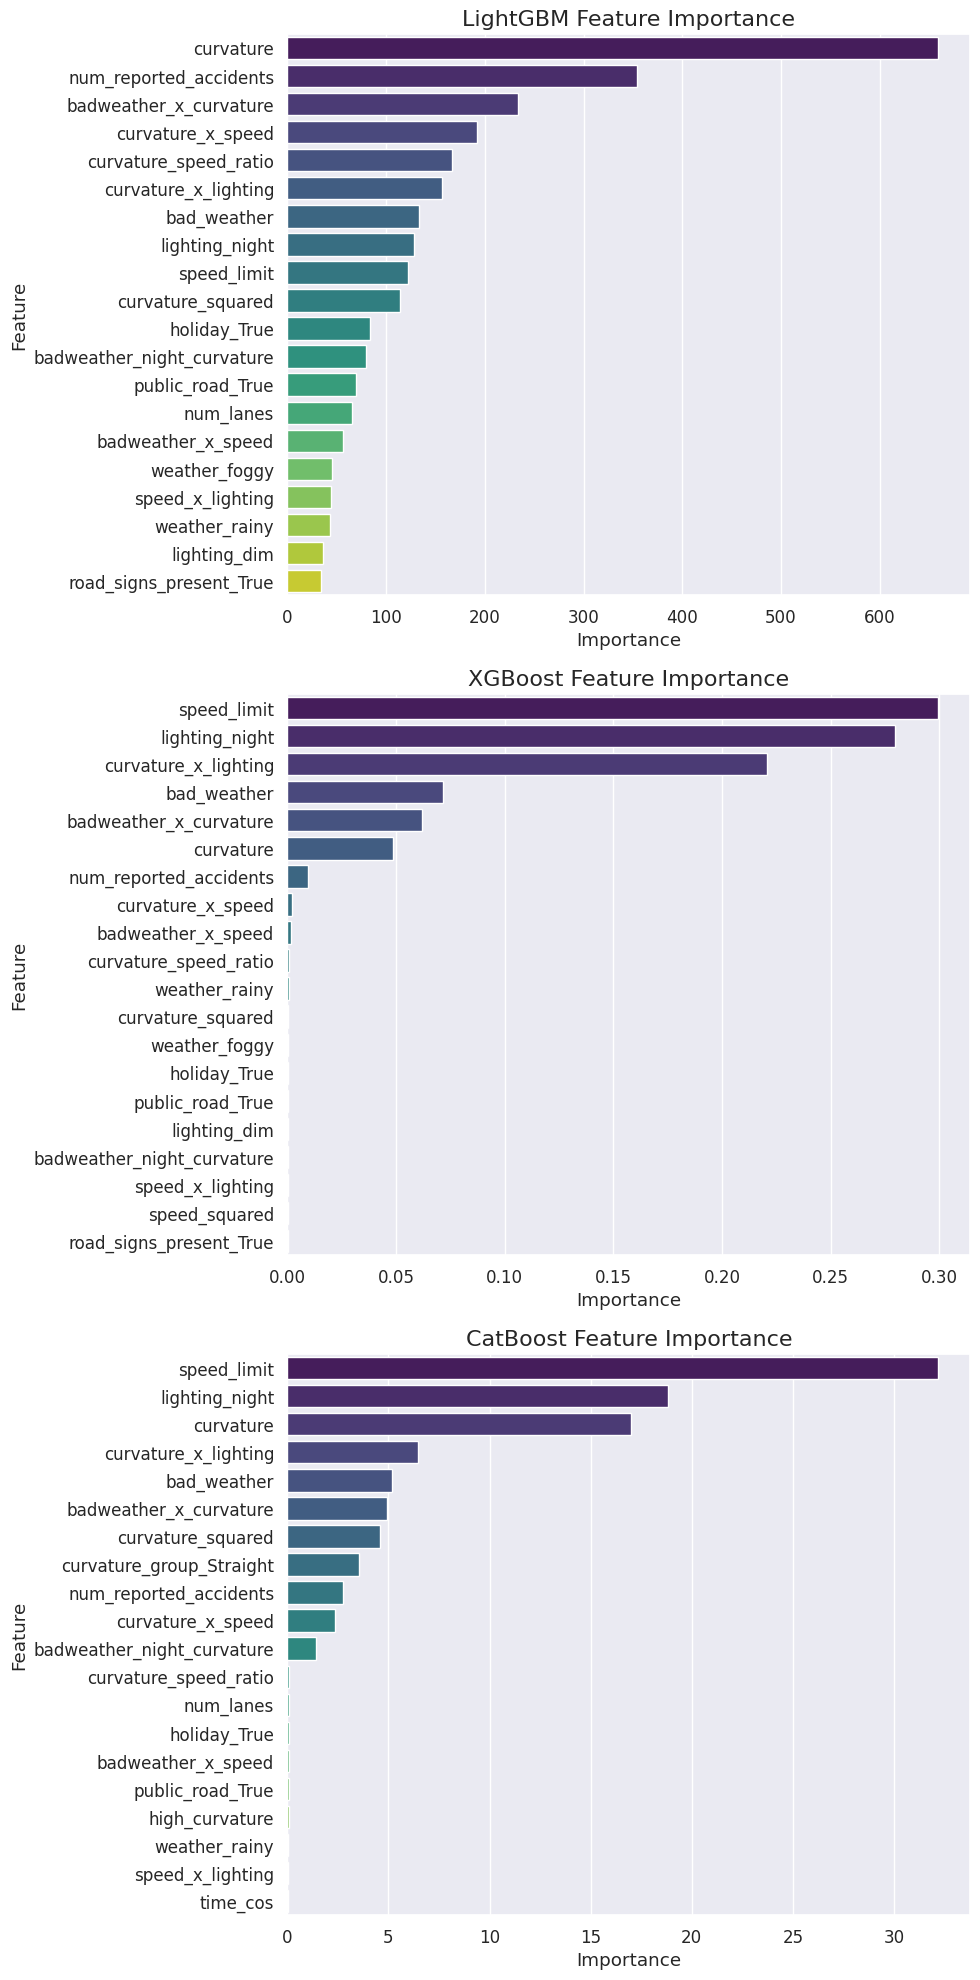

In [38]:
models = {
    'LightGBM': lgbm,
    'XGBoost': xgbr,
    'CatBoost': catr
}
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))
for i, (model_name, model) in enumerate(models.items()):

    feature_importances = pd.DataFrame({
        'feature': X_final.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    ax = axes[i]

    sns.barplot(
        x='importance',
        y='feature',
        data=feature_importances.head(20),
        palette='viridis',
        ax=ax
    )

    ax.set_title(f"{model_name} Feature Importance", fontsize=16)
    ax.set_xlabel('Importance')
    ax.set_ylabel('Feature')
plt.tight_layout()
plt.show()

<h3 style="color:red;font-weight:bold;">Q. Why use Permutation Importance?</h3>
<h3 style="color:blue;font-weight:bold;">
A. Permutation Importance is **a metric that directly measures how much the prediction accuracy** for unknown data would decrease if a particular feature were removed after model training.

Generally, Permutation Importance is considered **more reliable for assessing** whether a feature truly contributes to predictions.</h3>

Begin training LightGBM and calculating Permutation Importance.
Processing of LightGBM completed.
Begin training XGBoost and calculating Permutation Importance.
Processing of XGBoost completed.
Begin training CatBoost and calculating Permutation Importance.
Processing of CatBoost completed.


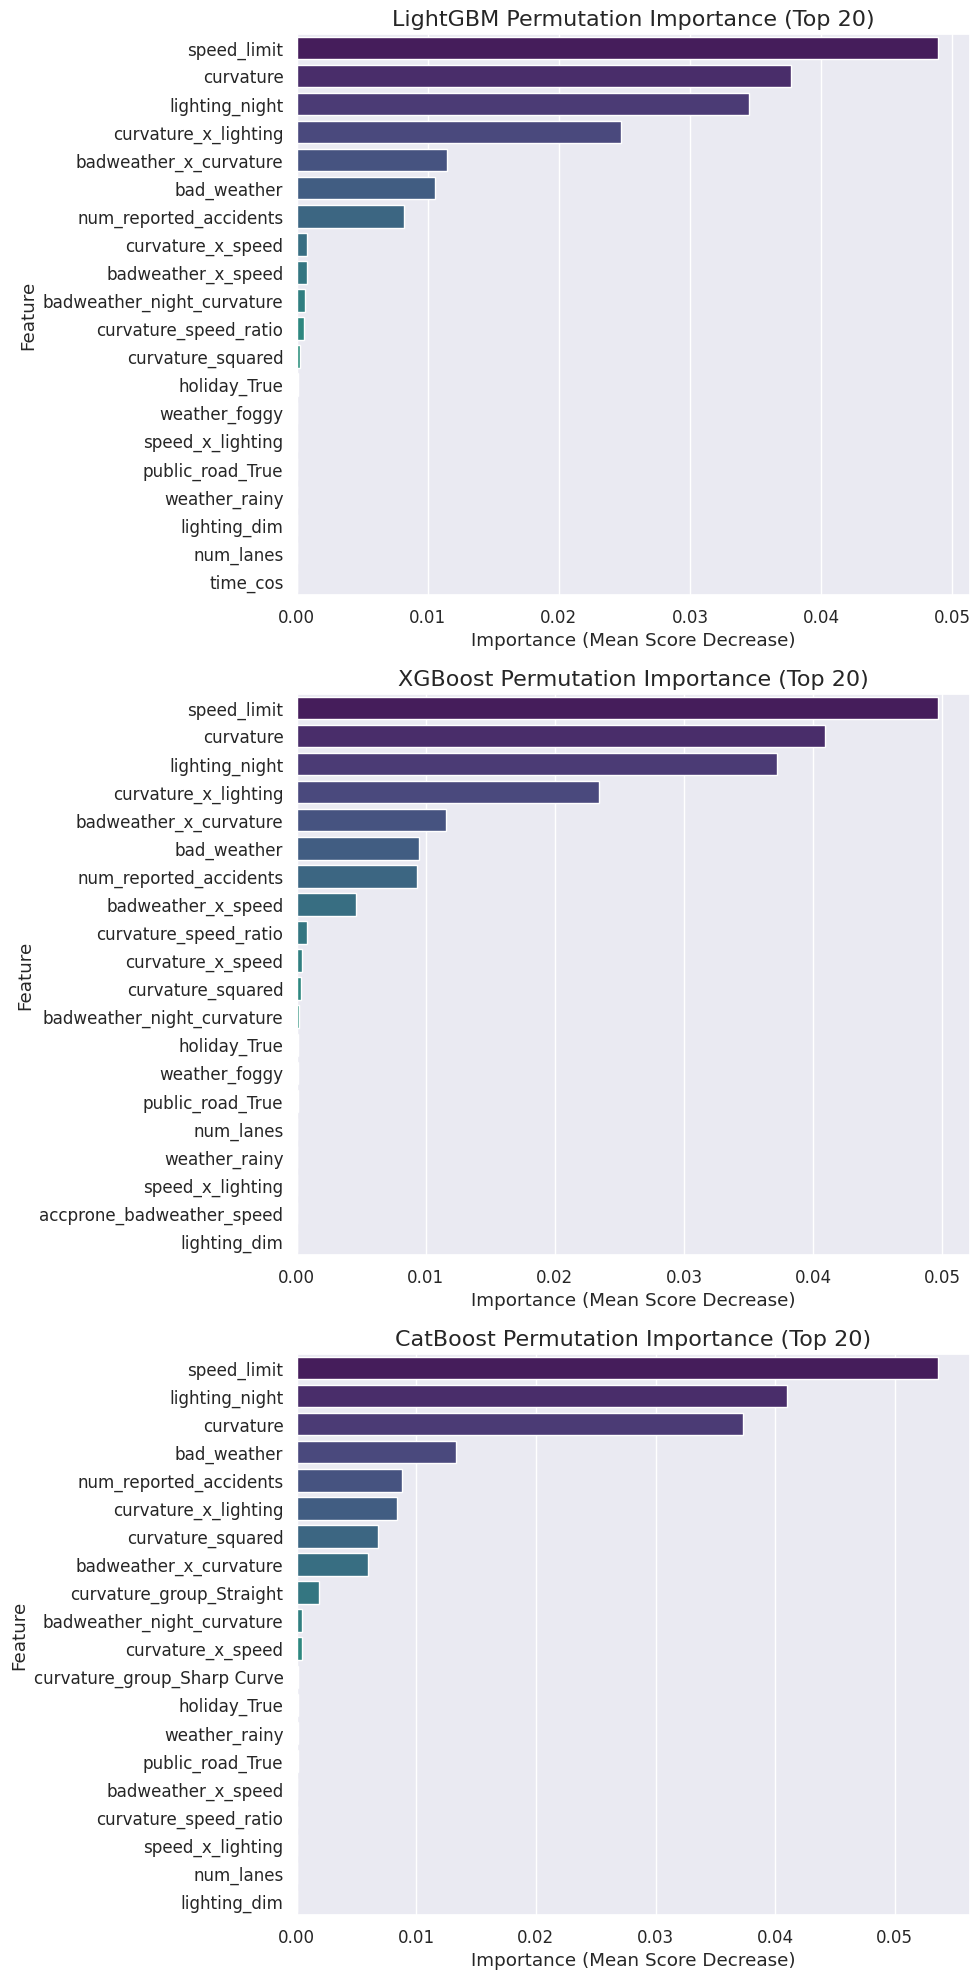


--- Features with importance below 0 in each model ---

[LightGBM]
                        feature  importance_mean
21                   high_speed     0.000000e+00
20               high_curvature     0.000000e+00
26                    acc_prone     0.000000e+00
16  curvature_group_Sharp Curve     0.000000e+00
17     curvature_group_Straight     0.000000e+00
4                      time_sin    -1.282437e-07

[XGBoost]
                        feature  importance_mean
16  curvature_group_Sharp Curve     0.000000e+00
20               high_curvature     0.000000e+00
21                   high_speed     0.000000e+00
26                    acc_prone     0.000000e+00
17     curvature_group_Straight     0.000000e+00
22                foggy_x_night    -1.608157e-08
4                      time_sin    -3.556467e-06

[CatBoost]
               feature  importance_mean
15  school_season_True    -3.691185e-07
7      road_type_urban    -1.005942e-06


In [39]:
X_train, X_val, y_train, y_val = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)

models = {
    'LightGBM': lgbm,
    'XGBoost': xgbr,
    'CatBoost': catr
}

y_val_log = np.log1p(y_val)
y_train_log = np.log1p(y_train)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))

low_importance_features = {}

for i, (model_name, model) in enumerate(models.items()):

    print(f"Begin training {model_name} and calculating Permutation Importance.")
    if model_name == 'CatBoost':
        model.fit(X_train, y_train_log, verbose=0)
    elif model_name == 'XGBoost':
        model.fit(X_train, y_train_log, verbose=0)
    else: 
        model.fit(X_train, y_train_log)

    result = permutation_importance(
        model,
        X_val,
        y_val_log,
        n_repeats=10,
        random_state=42,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    perm_importance = pd.DataFrame({
        'feature': X_val.columns,
        'importance_mean': result.importances_mean
    }).sort_values('importance_mean', ascending=False)

    ax = axes[i]

    sns.barplot(
        x='importance_mean',
        y='feature',
        data=perm_importance.head(20),
        palette='viridis',
        ax=ax
    )

    ax.set_title(f"{model_name} Permutation Importance (Top 20)", fontsize=16)
    ax.set_xlabel('Importance (Mean Score Decrease)')
    ax.set_ylabel('Feature')

    low_importance_features[model_name] = perm_importance[perm_importance['importance_mean'] <= 0]

    print(f"Processing of {model_name} completed.")

plt.tight_layout()

plt.show()

print("\n--- Features with importance below 0 in each model ---")
for model_name, features_df in low_importance_features.items():
    print(f"\n[{model_name}]")
    if features_df.empty:
        print("There were no features with a weight of 0 or less.")
    else:
        print(features_df)